# Search precursor for optimal time window

In [1]:
import pandas as pd
import numpy as np
import io
import scipy as sp
import scipy.fftpack
#import scipy.fft
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz, filtfilt, cheby2
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
#import h5py
#import windspectra as ws
#import PyOctaveBand
from matplotlib.font_manager import FontProperties

In [2]:
# Plot standardize
def showplot(axis=0,ls=1.5):
    plt.rcParams.update({'font.size': 18})
    #### Get handles and print plot ####
    handles, labels = ax[axis].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(ls, 0.6),frameon=False,prop={'size': 14})
    for i,a in enumerate(ax):
        #a.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.5)
        a.minorticks_on()
        #a.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
        a.grid(True)
        #for tick in a.get_xticklabels():
        #    tick.set_fontname("Open Sans")
        #for tick in a.get_yticklabels():
        #    tick.set_fontname("Open Sans")
    fig.tight_layout()
    plt.show()

In [3]:
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/utilities',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

import extractTimeSeries2 as eTS

## Create the CSV file

In [4]:
def datadict2csv(datadict, ptlist, filename, varlist=['velocityx','velocityy','velocityz']):
    header="Time coordinates[0] coordinates[1] coordinates[2] velocity_probe[0] velocity_probe[1] velocity_probe[2]\n"
    # get the time coordinate
    timevec = datadict[ptlist[0]]['time']
    with open(filename, 'w') as f:
        f.write(header)
        for  itime, t in enumerate(timevec):
            for pt in ptlist:
                p = datadict[pt]
                f.write('%f %f %f %f '%(t, p['x'], p['y'], p['z']))
                for v in varlist:
                    f.write('%f '%p[v][itime])
                f.write('\n')

In [5]:
ncfile='/lustre/orion/cfd162/scratch/lcheung/ALCC_Frontier_WindFarm/MedWS_LowTI/precursor6_7kmX2km_5m/post_processing/samplePlane_100000.nc'
# These are the locations of the domain center at lower rotor tip, hub-height, and upper rotor tip
# NOTE: they should be in sample plane indices, not physical coordinates
pt1 = (672,200,0)
pt2 = (672,200,1)
pt3 = (672,200,2)
ptlist=[pt1, pt2, pt3]
datfile='MedWS_LowTI_7x2.dat'
writedat=True

In [6]:
if writedat:
    data=eTS.extractpt(ncfile,ptlist, timesubset=None)
    print(data[pt1]['x'], data[pt1]['y'], data[pt1]['z'])
    datadict2csv(data, ptlist, datfile)

[============================================================] 100.0% 
3360.0 1000.0 30.0


## Load Precursor Data

In [7]:
precDataFile = {
    #"run1" : "./Probe_Turbine1_0.dat", 
    #"run1" : "./turbine1.dat", 
    "run1" : datfile, 
}

precData = {}

for c in precDataFile.keys():
    precData[c] = pd.read_csv(precDataFile[c],delim_whitespace=True,index_col=False)

preI = list(precDataFile.keys())

In [8]:
precData['run1']

,Time,coordinates[0],coordinates[1],coordinates[2],velocity_probe[0],velocity_probe[1],velocity_probe[2]
0,25000.00,3360.0,1000.0,30.0,7.174213,1.100551,0.081581
1,25000.00,3360.0,1000.0,150.0,8.864088,0.290551,0.170973
2,25000.00,3360.0,1000.0,270.0,9.850812,-0.998922,0.023342
3,25000.25,3360.0,1000.0,30.0,7.148758,1.087736,0.094083
4,25000.25,3360.0,1000.0,150.0,8.853564,0.277218,0.134914
...,...,...,...,...,...,...,...
46306,28858.75,3360.0,1000.0,150.0,9.272637,-0.109661,0.103746
46307,28858.75,3360.0,1000.0,270.0,10.030503,-1.071865,0.009173
46308,28859.00,3360.0,1000.0,30.0,7.239345,0.328806,-0.035163
46309,28859.00,3360.0,1000.0,150.0,9.266480,-0.116428,0.093930


## Search Precursor Data

In [9]:
#############################################
### User Input 
#############################################
prData = precData['run1']

dt = 0.4       # sim output time step
it = precData['run1'].Time[0]    # initial time
nt = len(np.array(prData['Time'][(prData['coordinates[2]']==150.000000)]))  # number of timesteps
#nt = len(np.array(prData['Time']))
print("nt: ",nt)
bt = 15       # bin time length in minutes
bl = bt*60/dt  # steps per bin
ol = 1        # steps to skip ahead in search

expU = 9.03
expShear = 0.171
expTI = 0.037
expWS = 270

#############################################

# Load precursor data
#prKsgs = prData['turbulent_ke_probe[0]']
prU = prData['velocity_probe[0]']
prV = prData['velocity_probe[1]']
prW = prData['velocity_probe[2]']
prH = prData['coordinates[2]']
prT = np.array(prData['Time'][(prH==150.000000)])

dx_range = 0.0001

H_low = 30.0 
U_low = np.array(prU[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
V_low = np.array(prV[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
W_low = np.array(prW[(prH>H_low-dx_range) & (prH<H_low+dx_range)])
Umag_low = np.sqrt(U_low**2 + V_low**2)

H_high = 270.0 
U_high = np.array(prU[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
V_high = np.array(prV[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
W_high = np.array(prW[(prH>H_high-dx_range) & (prH<H_high+dx_range)])
Umag_high = np.sqrt(U_high**2 + V_high**2)

H_hh = 150.0
U_hh = np.array(prU[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
V_hh = np.array(prV[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
W_hh = np.array(prW[(prH>H_hh-dx_range) & (prH<H_hh+dx_range)])
Umag_hh = np.sqrt(U_hh**2 + V_hh**2)

# Log law alpha - two point
alpha_inst = np.log(Umag_high/Umag_low)/np.log(H_high/H_low)

# Log law alpha - 3 point fit 
alpha_fit = np.zeros_like(alpha_inst)
def alpha_fit_fun(x,a,b):
    return b*x**a
umag_fit = np.asarray([Umag_low,Umag_hh,Umag_high])
z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
for i in range(0,umag_fit.shape[1]):
    popt,pcov  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,umag_fit[:,i])
    alpha_fit[i]  = popt[0]

#hub height wind direction
windDir_hh = 270-np.arctan2(V_hh, U_hh)*180.0/np.pi
        
# Velocity Fluctuations
Up_low = U_low-np.mean(U_low)
Vp_low = V_low-np.mean(V_low)
Wp_low = W_low-np.mean(W_low)
kres_low = 0.5*(Up_low**2 + Vp_low**2 + Wp_low**2)
Up_hh = U_hh-np.mean(U_hh)
Vp_hh = V_hh-np.mean(V_hh)
Wp_hh = W_hh-np.mean(W_hh)
kres_hh = 0.5*(Up_hh**2 + Vp_hh**2 + Wp_hh**2)
Up_high = U_high-np.mean(U_high)
Vp_high = V_high-np.mean(V_high)
Wp_high = W_high-np.mean(W_high)
kres_high = 0.5*(Up_high**2 + Vp_high**2 + Wp_high**2)

# Turbulence intensity
precResTI_inst = np.sqrt(Up_hh**2 + Vp_hh**2)/Umag_hh
precResTI = np.mean(precResTI_inst)

binstart = np.arange(0,nt-bl,ol)

# Create data structure for output
binout = {}
binout['Time']=np.empty(len(binstart))
binout['Umean']=np.empty(len(binstart))
binout['Alpha']=np.empty(len(binstart))
binout['Alpha-Fit']=np.empty(len(binstart))
binout['TI_res']=np.empty(len(binstart))
binout['WindDir']=np.empty(len(binstart))
#binout['TI_k']=np.empty(len(binstart)):w

#binout['TI_long']=np.empty(len(binstart))
binout['Diff_metric']=np.empty(len(binstart))
binout['Umag_Stdev']=np.empty(len(binstart))

for i,b in enumerate(binstart):
    bs = int(b)
    be = int(b + bl)
    rng = np.arange(bs,be)
    bin_U_hh = U_hh[rng]
    bin_V_hh = V_hh[rng]
    bin_W_hh = W_hh[rng]
    #bin_ksgs_hh = ksgs_hh[rng]
    bin_U_low = U_low[rng]
    bin_V_low = V_low[rng]
    bin_W_low = W_low[rng]
    bin_U_high = U_high[rng]
    bin_V_high = V_high[rng]
    bin_W_high = W_high[rng]
    
    bin_Ulong_hh = np.sqrt(bin_U_hh**2 + bin_U_hh**2)
    
    bin_Um_low = np.sqrt(bin_U_low**2 + bin_V_low**2)
    bin_Um_high = np.sqrt(bin_U_high**2 + bin_V_high**2)
    bin_Um_hh = np.sqrt(bin_U_hh**2 + bin_V_hh**2)
    
    bin_Up_low = bin_U_low - np.mean(bin_U_low)
    bin_Vp_low = bin_V_low - np.mean(bin_V_low)
    bin_Wp_low = bin_W_low - np.mean(bin_W_low)
    bin_kres_low = 0.5*(bin_Up_low**2 + bin_Vp_low**2 + bin_Wp_low**2)
    bin_Up_hh = bin_U_hh - np.mean(bin_U_hh)
    bin_Vp_hh = bin_V_hh - np.mean(bin_V_hh)
    bin_Wp_hh = bin_W_hh - np.mean(bin_W_hh)
    bin_kres_hh = 0.5*(bin_Up_hh**2 + bin_Vp_hh**2 + bin_Wp_hh**2)
    bin_Up_high = bin_U_high - np.mean(bin_U_high)
    bin_Vp_high = bin_V_high - np.mean(bin_V_high)
    bin_Wp_high = bin_W_high - np.mean(bin_W_high)
    bin_kres_high = 0.5*(bin_Up_high**2 + bin_Vp_high**2 + bin_Wp_high**2)

    bin_kresTI = np.sqrt(bin_Up_hh**2 + bin_Vp_hh**2)/bin_Um_hh

    bin_alpha_inst = np.log(bin_Um_high/bin_Um_low)/np.log(H_high/H_low)

    bin_wind_dir = np.mean(270-np.arctan2(bin_V_hh, bin_U_hh)*180.0/np.pi)
    
    bin_alpha =  np.log(np.mean(bin_Um_high)/np.mean(bin_Um_low))/np.log(H_high/H_low)
    bin_alpha2 =  np.mean(bin_alpha_inst)

    bin_umag_fit = np.asarray([np.mean(bin_Um_low),np.mean(bin_Um_hh),np.mean(bin_Um_high)])
    z_fit = np.asarray([float(H_low),float(H_hh),float(H_high)])
    popt,pcov  = sp.optimize.curve_fit(alpha_fit_fun,z_fit,bin_umag_fit)
    bin_alpha_fit  = popt[0]

    
    bin_Um_hh_mean = np.mean(bin_Um_hh)
    #bin_kTI_mean = np.mean(bin_kTI)
    bin_kresTI_mean = np.mean(bin_kresTI)
    #bin_longTI_mean = np.mean(bin_longTI)
    
    
    # Calculation of Diff Metric
    tiw = 3./9.
    aw = 1./9.
    uw = 5./9.

    alpha_diff = uw*np.abs(expShear - bin_alpha)/expShear
    alpha_fit_diff = uw*np.abs(expShear - bin_alpha_fit)/expShear
    
    Um_diff = aw*np.abs(expU - bin_Um_hh_mean)/expU
    #kTI_diff = tiw*np.abs(expTI - bin_kTI_mean)/expTI
    kresTI_diff = tiw*np.abs(expTI - bin_kresTI_mean)/expTI
    #longTI_diff = tiw*np.abs(explongTI - bin_longTI_mean)/explongTI
    
    umag_stdev = np.std(bin_Um_hh)
    
    #Original Weighting 
    #metric = 5*alpha_diff/5 + 25*Um_diff/5 + 5*kresTI_diff/5

    #Equal Weighting 
    #metric = alpha_diff + Um_diff + kresTI_diff
    
    #Equal Weighting with alpha fit 
    metric = alpha_fit_diff + Um_diff + kresTI_diff
   
    binout['Time'][i] = it + b*dt
    binout['Umean'][i]=bin_Um_hh_mean
    binout['Alpha'][i]=bin_alpha
    binout['Alpha-Fit'][i]=bin_alpha_fit
    binout['TI_res'][i]=bin_kresTI_mean
    binout['WindDir'][i]=bin_wind_dir
    #binout['TI_k'][i]=bin_kTI_mean
    #binout['TI_long'][i]=bin_longTI_mean
    binout['Umag_Stdev'][i]=umag_stdev
    binout['Diff_metric'][i]=metric
    
    
searchData = pd.DataFrame(binout)

searchData


nt:  15437


,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Diff_metric,Umag_Stdev
0,25000.0,9.042805,0.171795,0.171909,0.033489,270.068055,0.034745,0.255558
1,25000.4,9.042684,0.171803,0.171916,0.033494,270.068773,0.034718,0.255705
2,25000.8,9.042590,0.171811,0.171923,0.033497,270.069615,0.034712,0.255812
3,25001.2,9.042519,0.171818,0.171929,0.033498,270.070616,0.034721,0.255888
4,25001.6,9.042468,0.171824,0.171935,0.033499,270.071780,0.034735,0.255938
...,...,...,...,...,...,...,...,...
13182,30272.8,9.118438,0.164143,0.164271,0.029131,270.202264,0.093844,0.208138
13183,30273.2,9.118503,0.164129,0.164257,0.029136,270.202641,0.093845,0.208168
13184,30273.6,9.118573,0.164115,0.164243,0.029140,270.203059,0.093851,0.208198
13185,30274.0,9.118646,0.164100,0.164228,0.029144,270.203521,0.093866,0.208225


## Filter Search Results

In [10]:
# Find mean metric
meandiff = np.mean(searchData['Diff_metric'])

# Some values
maxvel = 10
minvel = 8
maxalpha = 0.25
minti = 0.03

searchDataFilt = searchData[(searchData['Diff_metric']<meandiff) & (searchData['Umean']<maxvel) & (searchData['Umean']>minvel) & (searchData['Alpha-Fit']<maxalpha) ] #& (searchData['TI_long']>minti)

searchDataSort = searchDataFilt.sort_values(["Diff_metric"], ascending = (True)).reset_index(drop=True)

searchDataSort 


,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Diff_metric,Umag_Stdev
0,25080.8,9.039131,0.172243,0.172349,0.035249,270.056614,0.020265,0.274260
1,25081.2,9.039345,0.172238,0.172345,0.035248,270.057289,0.020265,0.274334
2,25081.6,9.039566,0.172235,0.172342,0.035245,270.058052,0.020286,0.274402
3,25080.4,9.038928,0.172249,0.172354,0.035249,270.056023,0.020286,0.274180
4,25082.0,9.039786,0.172232,0.172340,0.035241,270.058885,0.020323,0.274464
...,...,...,...,...,...,...,...,...
5715,27894.0,9.070355,0.164672,0.164571,0.031713,269.989801,0.069016,0.240091
5716,28234.8,9.096830,0.167138,0.167226,0.030791,269.982135,0.069020,0.235381
5717,28248.8,9.097046,0.166963,0.167070,0.030848,269.978257,0.069020,0.236105
5718,26983.6,9.088656,0.166526,0.166730,0.030959,270.128075,0.069020,0.234979


Best three bins: [25080.8 26791.6 28121.2]
1: Green, 2: Yellow, 3: Red


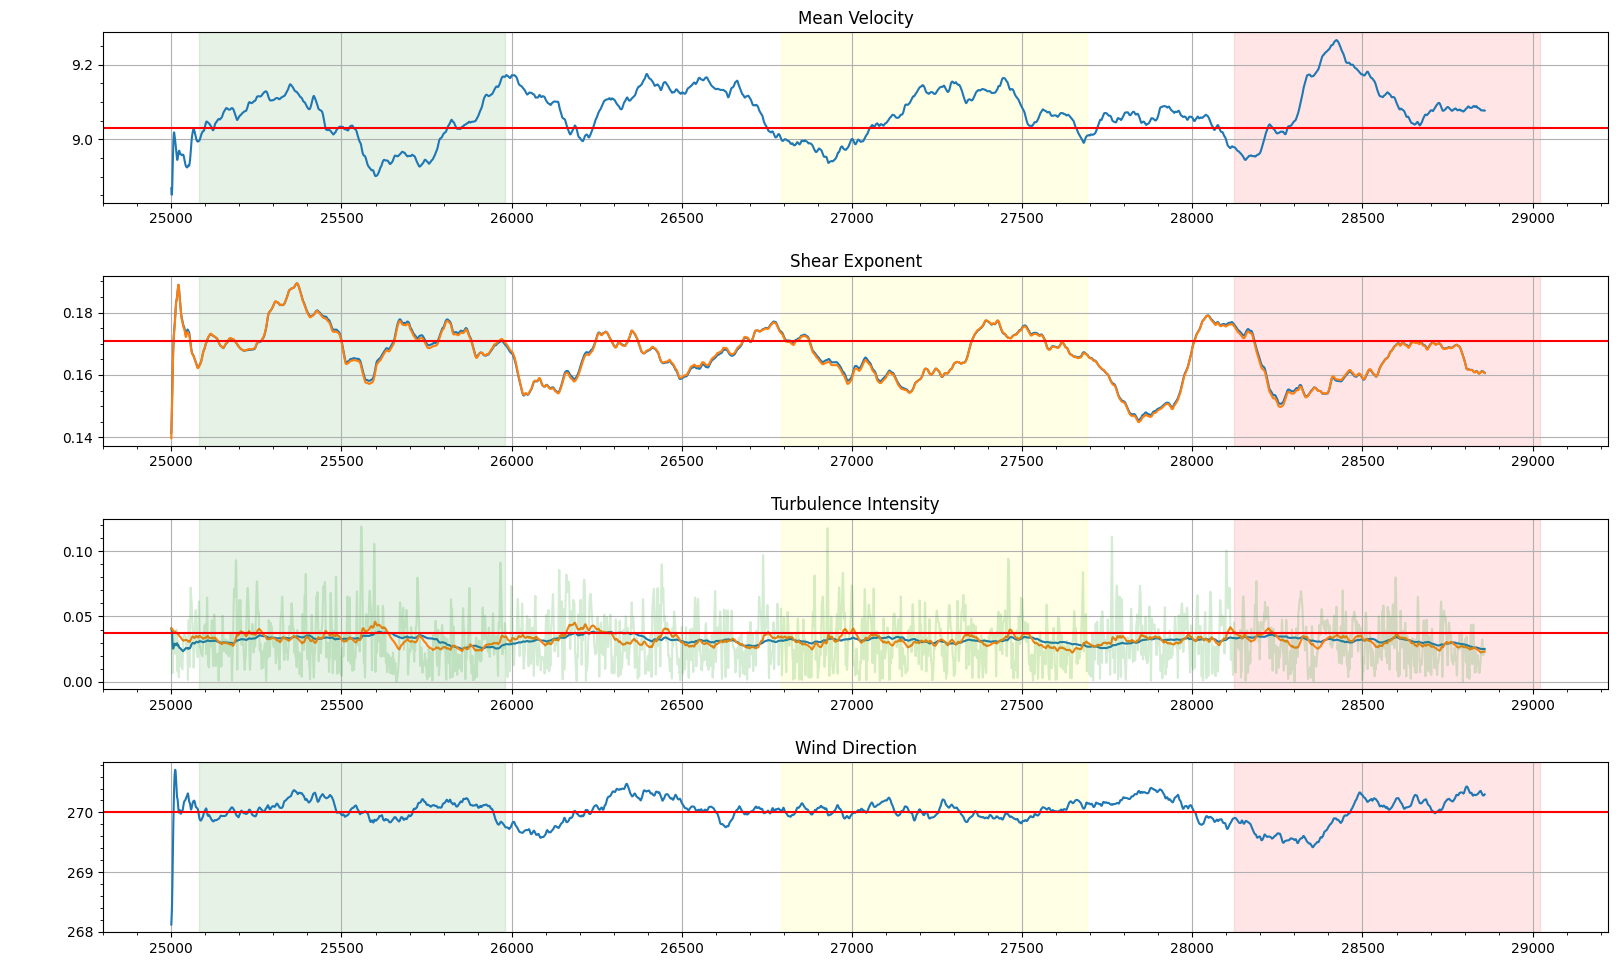

In [11]:
tm = 900  #Size of time-windows to average over. Should this also be size of searching window?
best_sep = tm/2.0 #should this be half of tm?
bin_size = bl*dt

plData = {}
plData['Time'] = prT
plData['Umag'] = Umag_hh
plData['Alpha'] = alpha_inst
plData['Alpha-Fit'] = alpha_fit
plData['WindDir'] = windDir_hh
#plData['TI'] = precTotTI_inst
plData['TI'] = precResTI_inst
maData = pd.DataFrame(plData)


umag_roll = maData['Umag'].rolling(tm,min_periods=1).mean()
alpha_roll = maData['Alpha'].rolling(tm,min_periods=1).mean()
alpha_fit_roll = maData['Alpha-Fit'].rolling(tm,min_periods=1).mean()
ti_ewa = maData['TI'].ewm(alpha=0.005, adjust=False).mean()
ti_roll = maData['TI'].rolling(tm,min_periods=1).mean()
windDir_roll = maData['WindDir'].rolling(tm,min_periods=1).mean()

fig, ax = plt.subplots(4,1, figsize=(16, 10))  

ax[0].plot(prT,umag_roll)
ax[1].plot(prT,alpha_roll)
ax[1].plot(prT,alpha_fit_roll)
ax[2].plot(prT,ti_roll)
ax[2].plot(prT,ti_ewa)
ax[2].plot(prT,maData['TI'],alpha=0.2)
ax[3].plot(prT,windDir_roll)

cbest = np.array([searchDataSort['Time'][0]])
c = 0

for i,s in enumerate(searchDataSort['Time']):
    if c == 0:
        cond1 = (searchDataSort['Time'][i]>(cbest[c]+best_sep))
        cond4 = (searchDataSort['Time'][i]<(cbest[c]-best_sep))
        if( cond1 | cond4):
            cbest = np.append(cbest,searchDataSort['Time'][i])
            c = c + 1
        if(c>=2):
            break
    if c > 0:
        cond1 = (searchDataSort['Time'][i]>(cbest[c]+best_sep))
        cond2 = (searchDataSort['Time'][i]>(cbest[c-1]+best_sep))
        cond3 = (searchDataSort['Time'][i]<(cbest[c]-best_sep))
        cond4 = (searchDataSort['Time'][i]<(cbest[c-1]-best_sep))
        if((cond1 & cond2) | (cond3 & cond4)):
            cbest = np.append(cbest,searchDataSort['Time'][i])
            c = c + 1
        if(c>=2):
            break


print("Best three bins: " + str(cbest))
print("1: Green, 2: Yellow, 3: Red")

for i,a in enumerate(ax):
    a.axvspan(cbest[0], cbest[0]+bin_size, alpha=0.1, color='green')
    a.axvspan(cbest[1], cbest[1]+bin_size, alpha=0.1, color='yellow')
    a.axvspan(cbest[2], cbest[2]+bin_size, alpha=0.1, color='red')
    

#Plot Target parameters
ax[0].axhline(y=expU,color='r')
ax[1].axhline(y=expShear,color='r')
ax[2].axhline(y=expTI,color='r')
ax[3].axhline(y=expWS,color='r')

ax[0].set_title("Mean Velocity")
ax[1].set_title("Shear Exponent")
ax[2].set_title("Turbulence Intensity")
ax[3].set_title("Wind Direction")

showplot(0,0)

In [12]:
searchDataSort[searchDataSort['Time'].isin(cbest)]

,Time,Umean,Alpha,Alpha-Fit,TI_res,WindDir,Diff_metric,Umag_Stdev
0,25080.8,9.039131,0.172243,0.172349,0.035249,270.056614,0.020265,0.274260
790,26791.6,9.119160,0.169398,0.169776,0.032863,270.154545,0.042347,0.254707
2489,28121.2,9.100571,0.166271,0.166294,0.032612,269.982681,0.055687,0.244979
